In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report


df = pd.read_csv("../data/ReviewsWithVotes.csv")

# fix votes nan to 0
df["votes"] = df["votes"].fillna(1)
df["votes"] = df["votes"] - 1 # remove self votes

# normalize votes
df["votes"] = df["votes"] / df["votes"].max()


high_quality_threshold = 0.45

df["imputed_quality"] = (df["votes"] >= high_quality_threshold)*1


# convert boolean cols to int
df["again"] = df["again"].astype(int)
df["instructorEnjoyed"] = df["instructorEnjoyed"].astype(int)
df["instructorAgain"] = df["instructorAgain"].astype(int)




def get_vectorizer(df, text_column):
    """
    Vectorize the text column
    """
    vect = TfidfVectorizer(
        max_features=1000,
        max_df=0.8,
        min_df=0.1,
        stop_words="english",
    )
    vect.fit_transform(df[text_column])
    return vect






In [2]:
df["imputed_quality"].value_counts()

0    1638
1     287
Name: imputed_quality, dtype: int64

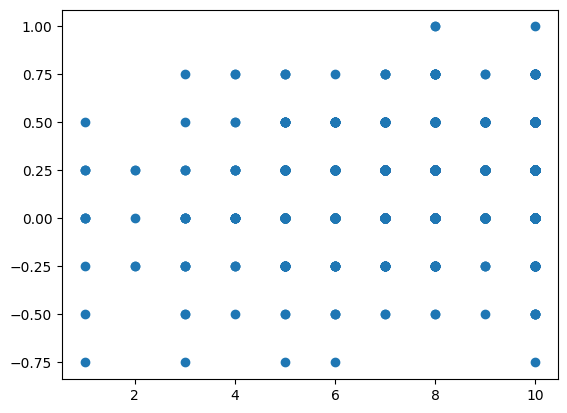

In [3]:
import matplotlib.pyplot as plt

# plt.hist(df["votes"], bins=6)


plt.scatter(df["instructorEnthusiasm"], df["votes"]) # these won't work



In [4]:
high_quality_df = df[df["imputed_quality"] == 1]


v = get_vectorizer(high_quality_df, "content")


X = v.transform(high_quality_df["content"])

print(v.get_feature_names_out())


bad_quality_df = df[df["votes"] < 0.25]

v_bad = get_vectorizer(bad_quality_df, "content")
X_bad = v_bad.transform(bad_quality_df["content"])

print(v_bad.get_feature_names_out())




['assignments' 'class' 'classes' 'course' 'definitely' 'did' 'difficult'
 'does' 'easy' 'engaging' 'enjoyed' 'exams' 'experience' 'extremely'
 'fair' 'final' 'fun' 'good' 'great' 'homework' 'hours' 'interested'
 'interesting' 'learn' 'learned' 'learning' 'lecture' 'lectures' 'like'
 'little' 'long' 'lot' 'material' 'overall' 'papers' 'passionate' 'pretty'
 'problem' 'prof' 'professor' 'questions' 'reading' 'readings' 'really'
 'recommend' 'semester' 'sets' 'students' 'super' 'taking' 'teaching'
 'time' 'understanding' 'way' 'week' 'work']
['class' 'course' 'definitely' 'difficult' 'easy' 'exams' 'good' 'great'
 'homework' 'interesting' 'just' 'lectures' 'like' 'lot' 'material'
 'pretty' 'prof' 'professor' 'reading' 'readings' 'really' 'recommend'
 'students' 'super' 'time' 'work']


In [5]:
# y = df["imputed_quality"]

# x_df = pd.DataFrame(X.toarray(), columns=v.get_feature_names_out())
# # x_df["imputed_quality"] = labels

# from sklearn.model_selection import train_test_split


# X_train, X_test, y_train, y_test = train_test_split(x_df, y, test_size=0.15)

# from sklearn.linear_model import LogisticRegression

# lr = LogisticRegression(penalty="l2")
# lr.fit(X_train, y_train)

# y_pred = lr.predict(X_test)

# print(classification_report(y_test, y_pred))







In [6]:
sliders = [
    "rating",
    "difficulty",
    "value",
    "instructorEffectiveness",
    "instructorAccommodationLevel",
    "instructorEnthusiasm",
]

def get_default_slider_mse(row):
    return np.mean((row[sliders] - 5)**2)

df["default_mse"] = df.apply(get_default_slider_mse, axis=1)

In [7]:
def get_review_content_length(row):
    return (len(row["content"]) - 200)/200

df["content_length"] = df.apply(get_review_content_length, axis=1)


In [8]:
def review_content_larger_than_250(row):
    return len(row["content"]) > 250

df["content_larger_than_250"] = df.apply(review_content_larger_than_250, axis=1)

In [9]:
# quality vs content_larger_than_250

# df["content_larger_than_250"].value_counts()

# df["imputed_quality"].value_counts()

df[df["content_larger_than_250"] == False]["imputed_quality"].value_counts()

0    469
1     12
Name: imputed_quality, dtype: int64

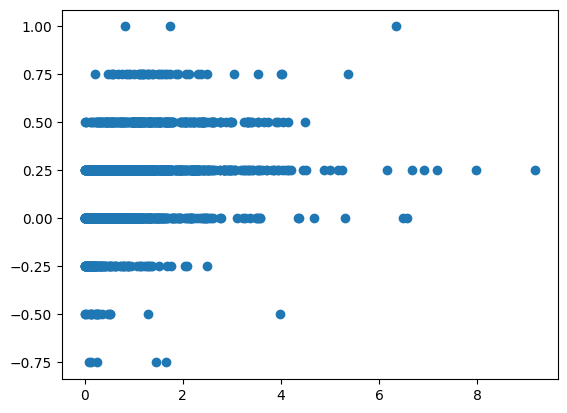

In [10]:
plt.figure()


plt.scatter(df["content_length"], df["votes"])

plt.show()

In [11]:
def get_average_sentence_length(row):
    return len(row["content"].split(" ")) / len(row["content"].split("."))


df["average_sentence_length"] = df.apply(get_average_sentence_length, axis=1)

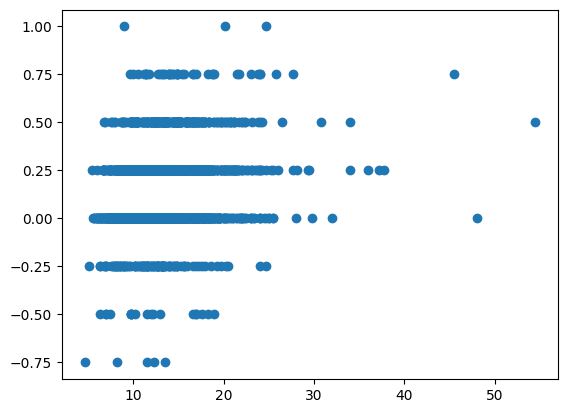

In [12]:
plt.figure()

plt.scatter(df["average_sentence_length"], df["votes"])

plt.show()

In [13]:
slider_cols = ["value", "difficulty", "rating", "instructorEffectiveness", "instructorEnthusiasm", "instructorAccommodationLevel"]

def get_variance(vals):
    return np.var(vals)

columns = ["value", "difficulty", "rating", "again", "instructorEffectiveness", "instructorEnthusiasm", "instructorAccommodationLevel", "instructorEnjoyed", "instructorAgain"]


default_slider_vals = {
    "value": 5,
    "difficulty": 5,
    "rating": 5,
    "again": 0,
    "instructorEffectiveness": 5,
    "instructorEnthusiasm": 5,
    "instructorAccommodationLevel": 5,
    "instructorEnjoyed": 0,
    "instructorAgain": 0
}

overly_negative_vals = {
    "value": 1,
    "difficulty": 10,
    "rating": 1,
    "again": 0,
    "instructorEffectiveness": 1,
    "instructorEnthusiasm": 1,
    "instructorAccommodationLevel": 1,
    "instructorEnjoyed": 0,
    "instructorAgain": 0
}

overly_positive_vals = {
    "value": 10,
    "difficulty": 1,
    "rating": 10,
    "again": 1,
    "instructorEffectiveness": 10,
    "instructorEnthusiasm": 10,
    "instructorAccommodationLevel": 10,
    "instructorEnjoyed": 1,
    "instructorAgain": 1
}

default_slider_vals_list = [default_slider_vals[col] for col in columns]
overly_negative_vals_list = [overly_negative_vals[col] for col in columns]
overly_positive_vals_list = [overly_positive_vals[col] for col in columns]

def get_mse(vals, expected_vals):
    return np.mean(np.square(vals-expected_vals))


In [14]:
df["default_mse"] = df[columns].apply(get_mse, axis=1, args=(default_slider_vals_list,))
df["overly_negative_mse"] = df[columns].apply(get_mse, axis=1, args=(overly_negative_vals_list,))
df["overly_positive_mse"] = df[columns].apply(get_mse, axis=1, args=(overly_positive_vals_list,))

df["slider_variance"] = df[slider_cols].apply(get_variance, axis=1)

In [15]:
# readability
# from readability import flesch_reading_ease, smog_index, dale_chall_readability_score

from textstat.textstat import textstatistics
import math


flesch_reading_ease = lambda x: textstatistics().flesch_reading_ease(x)
smog_index = lambda x: textstatistics().smog_index(x)
dale_chall_readability_score = lambda x: textstatistics().dale_chall_readability_score(x)

def get_fre_readability_score(row):
    return flesch_reading_ease(row["content"])

def get_smog_readability_score(row):
    return smog_index(row["content"])

def get_dale_chall_readability_score(row):
    return dale_chall_readability_score(row["content"])

df["fre_readability"] = df.apply(get_fre_readability_score, axis=1)
df["smog_readability"] = df.apply(get_smog_readability_score, axis=1)
df["dale_chall_readability"] = df.apply(get_dale_chall_readability_score, axis=1)


In [16]:
import math

def char_freq(text: str):
    """Calculates the frequency of each character in the text"""
    freq = {}
    for char in text:
        freq[char] = freq.get(char, 0) + 1
    return freq

def shannon_entropy(text: str):
    """Calculates the Shannon entropy of a text string"""
    length = len(text)
    freq = char_freq(text)

    entropy = 0
    for char in freq:
        prob = freq[char] / length
        entropy -= prob * math.log(prob, 2)

    return entropy


def get_review_entropy(row):
    return shannon_entropy(row["content"])

df["entropy"] = df.apply(get_review_entropy, axis=1)

In [67]:
def get_space_length_ratio(row):
    return len(row["content"].split(" ")) / len(row["content"])

def get_percent_difficult_words(row):
    # percent longer than 9 characters (2x average)
    return len([word for word in row["content"].split(" ") if len(word) > 9]) / len(row["content"].split(" "))


def get_count_period(row):
    return len([char for char in row["content"] if char == "."])

def get_count_exclamation(row):
    return len([char for char in row["content"] if char == "!"])

def get_count_question(row):
    return len([char for char in row["content"] if char == "?"])

def get_ratio_question_marks(row):
    return get_count_question(row) / len(row["content"])

def get_ratio_exclamation_marks(row):
    return get_count_exclamation(row) / len(row["content"])


def get_all_cap_words(row):
    return len([word for word in row["content"].split(" ") if word.isupper() and len(word) > 1])

def get_all_cap_words_ratio(row):
    return get_all_cap_words(row) / len(row["content"].split(" "))

# Features:
# Space to length ratio
# Percent difficult words
# Ratio of question marks
# Ratio of exclamation marks

df["space_length_ratio"] = df.apply(get_space_length_ratio, axis=1)
df["percent_difficult_words"] = df.apply(get_percent_difficult_words, axis=1)
df["ratio_question_marks"] = df.apply(get_ratio_question_marks, axis=1)
df["ratio_exclamation_marks"] = df.apply(get_ratio_exclamation_marks, axis=1)
df["ratio_all_cap_words"] = df.apply(get_all_cap_words_ratio, axis=1)



In [17]:
def word_freq(text: str):
    """Calculates the frequency of each word in the text"""
    freq = {}
    for word in text.split(" "):
        freq[word] = freq.get(word, 0) + 1
    return freq

def word_shannon_entropy(text: str):
    """Calculates the Shannon entropy of a text string"""
    length = len(text.split(" "))
    freq = word_freq(text)

    entropy = 0
    for word in freq:
        prob = freq[word] / length
        entropy -= prob * math.log(prob, 2)

    return entropy

def get_review_word_entropy(row):
    return word_shannon_entropy(row["content"].lower())

df["word_entropy"] = df.apply(get_review_word_entropy, axis=1)
df["word_diversity"] = df["word_entropy"] / df["content_length"] #this can create inf
df["word_diversity"] = df["word_diversity"].replace([np.inf, -np.inf], np.nan)
df["word_diversity"] = df["word_diversity"].fillna(df["word_diversity"].max())

In [18]:
from datetime import datetime, date, timedelta

def convert_term_string_to_date(term):
    # F22 -> 2022-09-01
    # S21 -> 2021-02-01
    # W21 -> 2021-01-01

    year = int(term[1:3])
    year = 2000 + year #Y2K baby!
    
    t_obj = {
        "F": date(year, 9, 1),
        "S": date(year, 2, 1),
        "W": date(year, 1, 1)
    }

    return t_obj[term[0]]



def time_between_course_and_review(row):
    # example reviewDate: 2022-10-24 03:16:49.083+00
    # only care aoout the date, not the time
    format = "%Y-%m-%d"
    time_string = row["reviewDate"]
    course_date = convert_term_string_to_date(row["semester"])

    date_string = time_string.split(" ")[0]


    review_date = datetime.strptime(date_string, format).date()

    return ((review_date - course_date).days) / 365



In [19]:
df["time_between_course_and_review"] = df.apply(time_between_course_and_review, axis=1)

In [20]:
# Sentiment Analysis

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

def get_sentiment_scores(row):
    return analyser.polarity_scores(row["content"])["compound"]

def get_neutrality_scores(row):
    return analyser.polarity_scores(row["content"])["neu"]

df["sentiment_scores"] = df.apply(get_sentiment_scores, axis=1)
df["neutrality_scores"] = df.apply(get_neutrality_scores, axis=1)

In [21]:
# Polarity
# a measure of if sentiment matches the ratings

def get_consistent_polarity(row):
    same_sign = 1 if row["sentiment_scores"] * (row["rating"]-5) > 0 else 0
    magnitude_threshold = 0.2
    same_magnitude = 1 if (abs(row["sentiment_scores"]) - abs(row["rating"]/10)) < magnitude_threshold else 0
    return same_sign * same_magnitude

def get_polarity(row):
    return row["sentiment_scores"] - ((row["rating"]-5)/10)

df["consistent_polarity"] = df.apply(get_consistent_polarity, axis=1)
df["polarity"] = df.apply(get_polarity, axis=1)

In [22]:
# KNN avg distance to nearest neighbor

from sklearn.neighbors import NearestNeighbors
import math

k = 5

def get_knn_avg_distance(df, row):

    X = df[["sentiment_scores", "neutrality_scores", "consistent_polarity", "polarity", "fre_readability", "smog_readability", "dale_chall_readability", "entropy", "word_entropy", "word_diversity", "time_between_course_and_review"]].to_numpy()

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X)

    distances, indices = nbrs.kneighbors([row[["sentiment_scores", "neutrality_scores", "consistent_polarity", "polarity", "fre_readability", "smog_readability", "dale_chall_readability", "entropy", "word_entropy", "word_diversity", "time_between_course_and_review"]].to_numpy()])
    return distances[0].mean()



def get_knn_same_course_avg_distance(df, row):

    columns = [
        "rating",
        "difficulty",
        "value",
        "hours",
        "again",
        
        "default_mse",
        "content_length",
        "sentiment_scores",
    ]

    courseID = row["courseID"]
    X = df[df["courseID"] == courseID][columns].to_numpy()

    n_neighbors = min(k, len(X))

    if n_neighbors == 0:
        return math.nan

    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(X)

    distances, indices = nbrs.kneighbors([row[columns].to_numpy()])

    return distances[0].mean()




df["knn_avg_distance"] = df.apply(lambda row: get_knn_avg_distance(df, row), axis=1)
df["knn_same_course_avg_distance"] = df.apply(lambda row: get_knn_same_course_avg_distance(df, row), axis=1)

# replace knn_same_course_avg_distance with avg if nan or inf
df["knn_same_course_avg_distance"] = df["knn_same_course_avg_distance"].replace([np.inf, -np.inf], np.nan)
df["knn_same_course_avg_distance"] = df["knn_same_course_avg_distance"].fillna(df["knn_same_course_avg_distance"].mean())




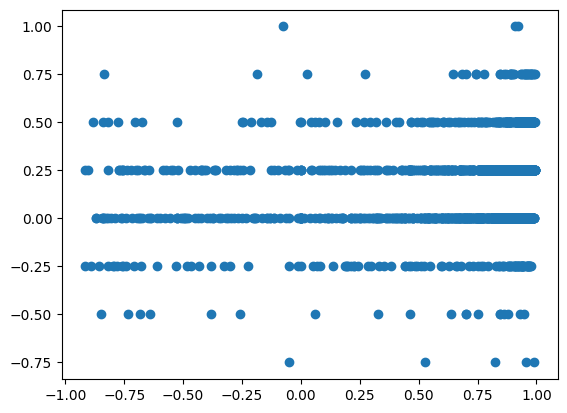

In [23]:
# sentiment_scores

plt.figure()

plt.scatter(df["sentiment_scores"], df["votes"])

plt.show()

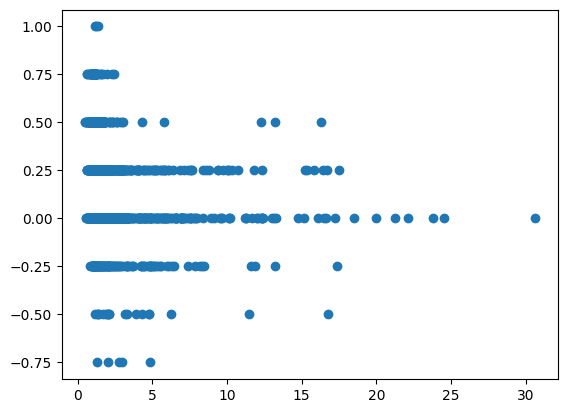

In [24]:
# entropy

plt.figure()

plt.scatter(df["knn_avg_distance"], df["votes"])

plt.show()

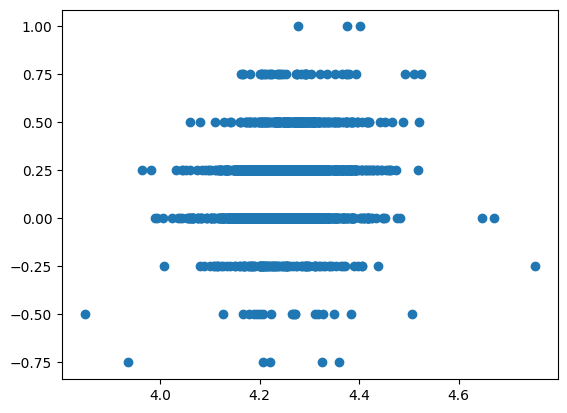

In [25]:
# entropy

plt.figure()

plt.scatter(df["entropy"], df["votes"])

plt.show()

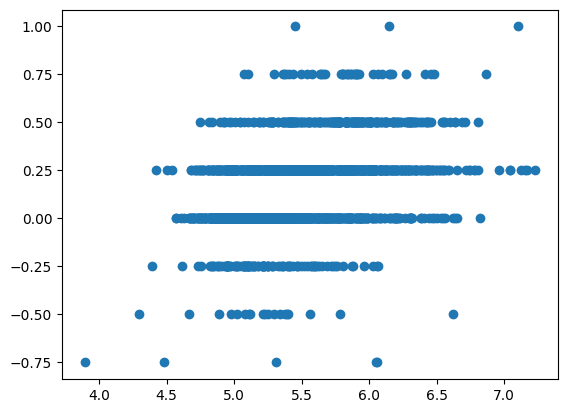

In [26]:
# word entropy

plt.figure()

plt.scatter(df["word_entropy"], df["votes"])

plt.show()

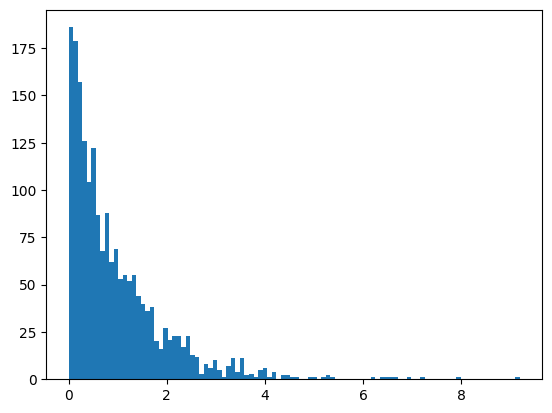

In [27]:
# hist of content length

plt.figure()

plt.hist(df["content_length"], bins=100)

plt.show()

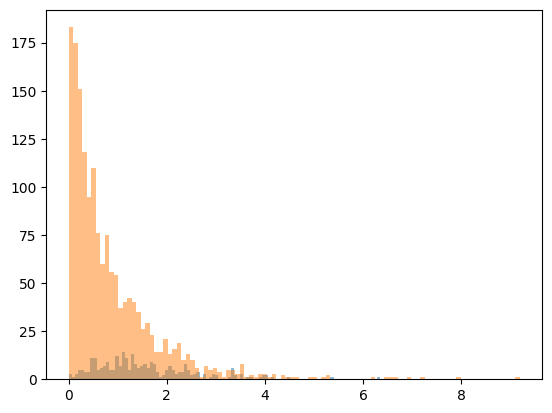

In [28]:
# hist of content length x imputed_quality

plt.figure()

plt.hist(df[df["imputed_quality"] == 1]["content_length"], bins=100, alpha=0.5, label="imputed_quality = 1")
plt.hist(df[df["imputed_quality"] == 0]["content_length"], bins=100, alpha=0.5, label="imputed_quality = 0")

plt.show()

<AxesSubplot: xlabel='content_length', ylabel='Density'>

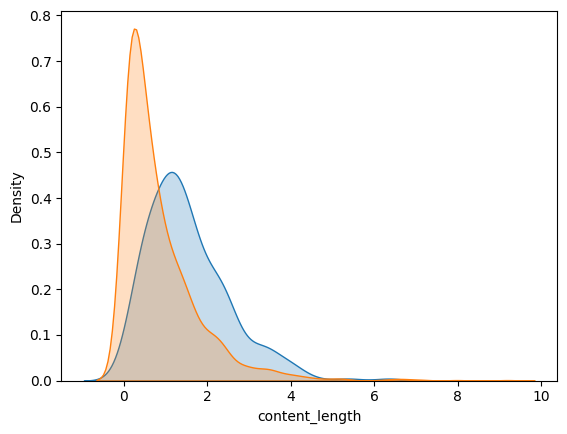

In [40]:
sns.kdeplot(df[df["imputed_quality"] == 1]["content_length"], fill=True, label="imputed_quality = 1")
sns.kdeplot(df[df["imputed_quality"] == 0]["content_length"], fill=True, label="imputed_quality = 0")

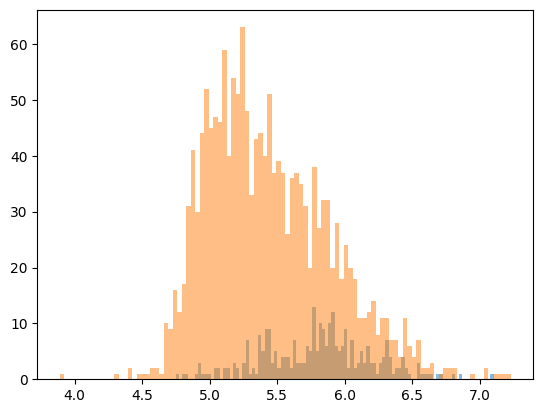

In [29]:

plt.figure()

plt.hist(df[df["imputed_quality"] == 1]["word_entropy"], bins=100, alpha=0.5, label="imputed_quality = 1")
plt.hist(df[df["imputed_quality"] == 0]["word_entropy"], bins=100, alpha=0.5, label="imputed_quality = 0")

plt.show()

<AxesSubplot: xlabel='word_entropy', ylabel='Density'>

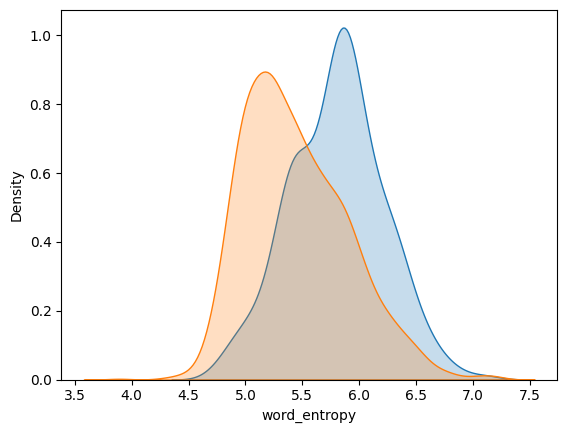

In [38]:
sns.kdeplot(df[df["imputed_quality"] == 1]["word_entropy"], fill=True, label="imputed_quality = 1")
sns.kdeplot(df[df["imputed_quality"] == 0]["word_entropy"], fill=True, label="imputed_quality = 0")

<AxesSubplot: xlabel='space_length_ratio', ylabel='Density'>

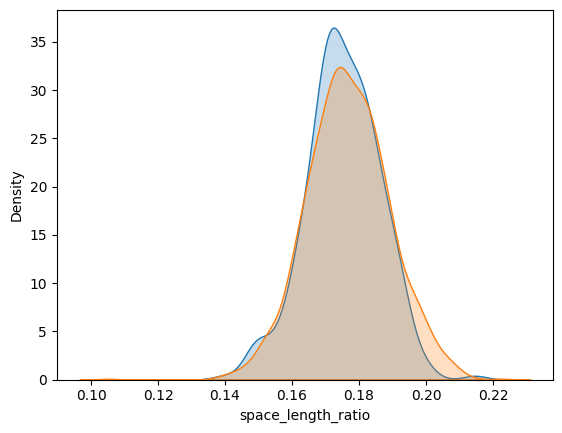

In [54]:
sns.kdeplot(df[df["imputed_quality"] == 1]["space_length_ratio"], fill=True, label="imputed_quality = 1")
sns.kdeplot(df[df["imputed_quality"] == 0]["space_length_ratio"], fill=True, label="imputed_quality = 0")

<AxesSubplot: xlabel='average_sentence_length', ylabel='Density'>

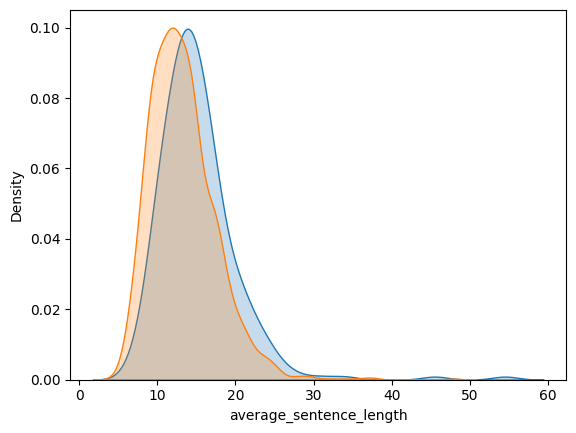

In [66]:
sns.kdeplot(df[df["imputed_quality"] == 1]["average_sentence_length"], fill=True, label="imputed_quality = 1")
sns.kdeplot(df[df["imputed_quality"] == 0]["average_sentence_length"], fill=True, label="imputed_quality = 0")

<AxesSubplot: xlabel='ratio_all_cap_words', ylabel='Density'>

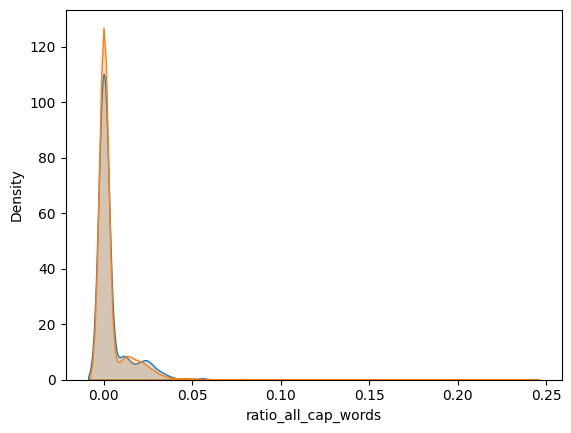

In [68]:
sns.kdeplot(df[df["imputed_quality"] == 1]["ratio_all_cap_words"], fill=True, label="imputed_quality = 1")
sns.kdeplot(df[df["imputed_quality"] == 0]["ratio_all_cap_words"], fill=True, label="imputed_quality = 0")

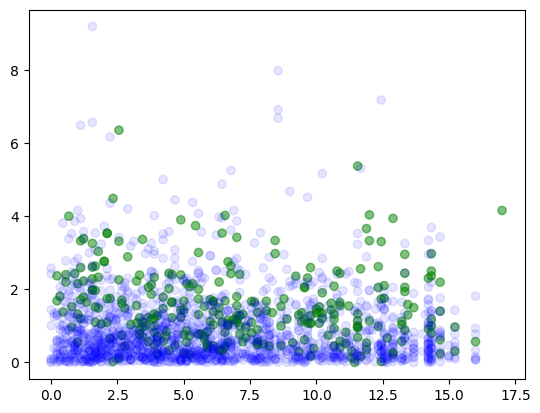

In [30]:
plt.figure()

color_map = {
    0: "blue",
    1: "green"
}

alpha_map = {
    0: 0.1,
    1: 0.5
}

ax = plt.scatter(df["default_mse"], df["content_length"], c=df["imputed_quality"].map(color_map), alpha=df["imputed_quality"].map(alpha_map))

plt.show()

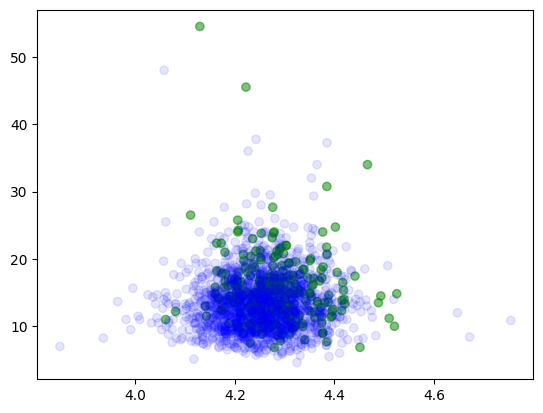

In [31]:
plt.figure()

color_map = {
    0: "blue",
    1: "green"
}

alpha_map = {
    0: 0.1,
    1: 0.5
}

ax = plt.scatter(df["entropy"], df["average_sentence_length"], c=df["imputed_quality"].map(color_map), alpha=df["imputed_quality"].map(alpha_map))

plt.show()

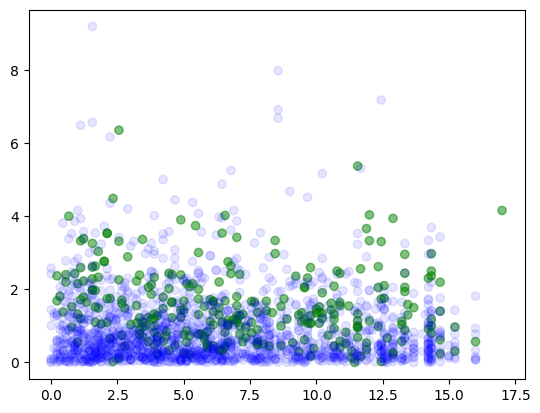

In [32]:
plt.figure()

color_map = {
    0: "blue",
    1: "green"
}

alpha_map = {
    0: 0.1,
    1: 0.5
}

ax = plt.scatter(df["default_mse"], df["content_length"], c=df["imputed_quality"].map(color_map), alpha=df["imputed_quality"].map(alpha_map))

plt.show()

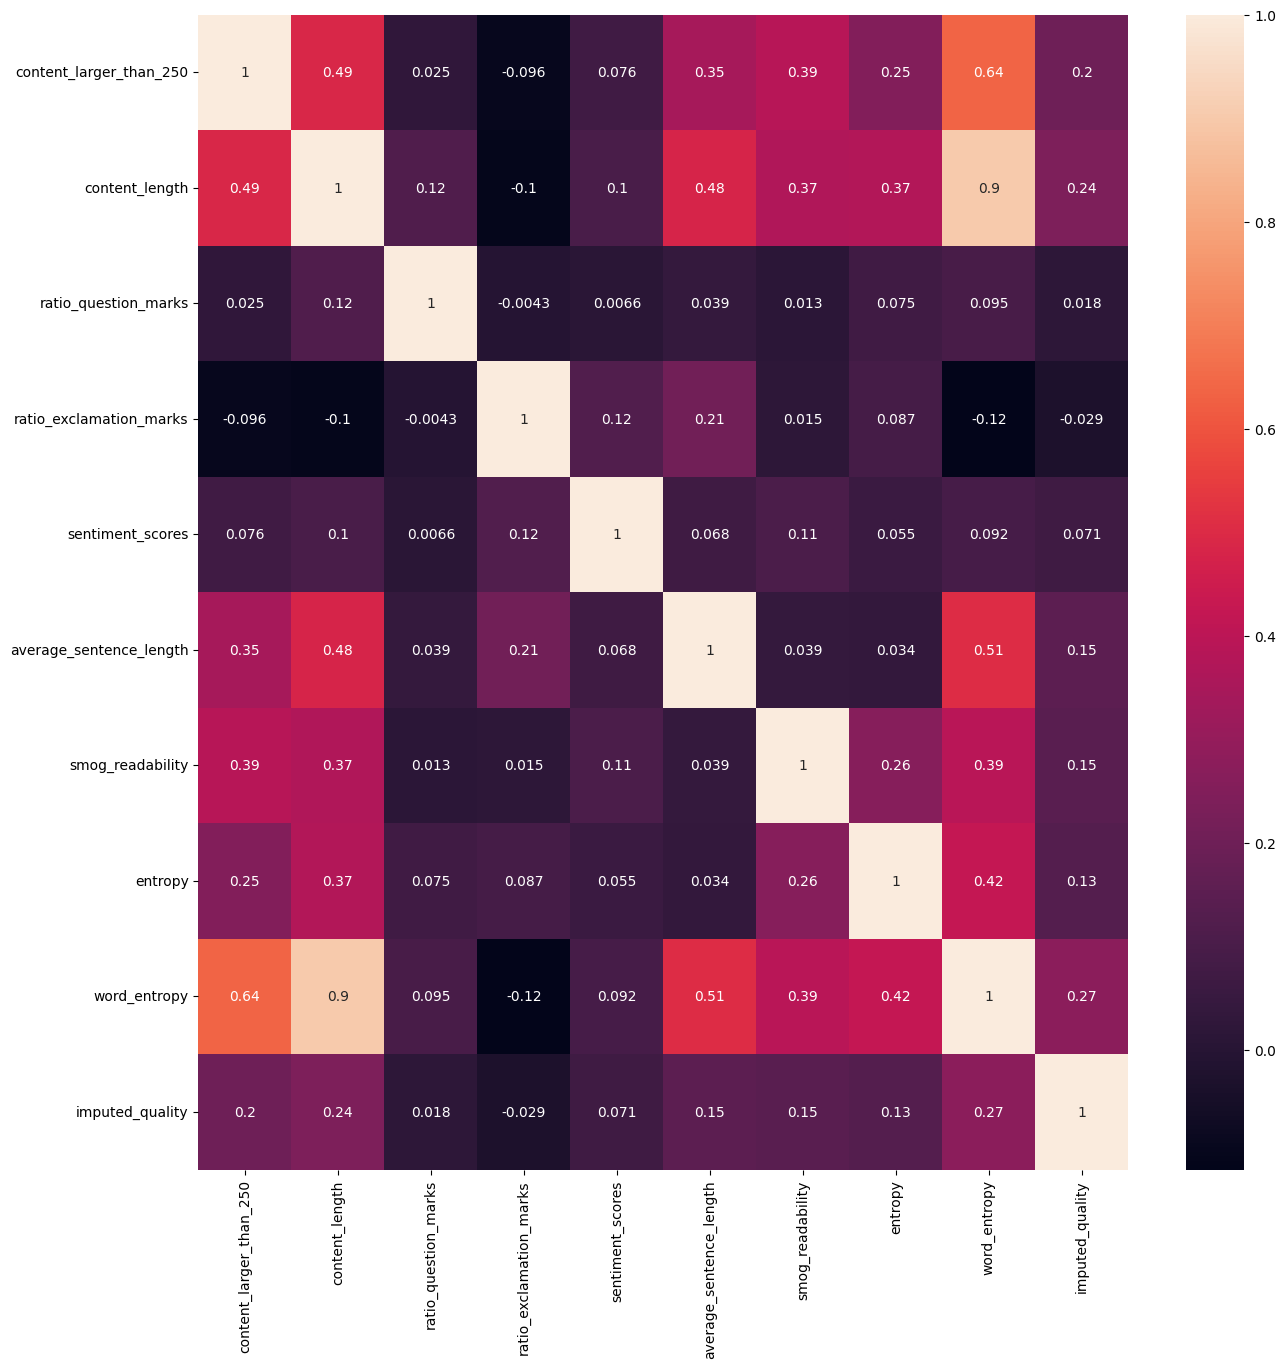

In [52]:
# cor
import seaborn as sns

corr_features = [
    # "default_mse",
    # "overly_negative_mse",
    # "overly_positive_mse",
    # "slider_variance",
    # "time_between_course_and_review",

    # "knn_avg_distance",
    "content_larger_than_250",
    "content_length",

    # "space_length_ratio", #sucks
    # "percent_difficult_words", #sucks
    # "ratio_question_marks", #sucks
    # "ratio_exclamation_marks", #sucks




    "sentiment_scores",
    # "neutrality_scores",
      
    # "polarity", #sucks
    # "consistent_polarity",
    
    "average_sentence_length",
    # "fre_readability",
    "smog_readability",
    # "dale_chall_readability",
    "entropy",
    "word_entropy",
    # "word_diversity",

]

corr_features.append("imputed_quality")

plt.figure(figsize=(15,15))

sns.heatmap(df[corr_features].corr(), annot=True)
            
plt.show()

In [34]:
# Q: which of the tdidf features are most important?


In [35]:
print(lr.coef_)

NameError: name 'lr' is not defined

In [ ]:
df_no_zero = df.copy()
df_no_zero= df_no_zero[df_no_zero["votes"] != 0]

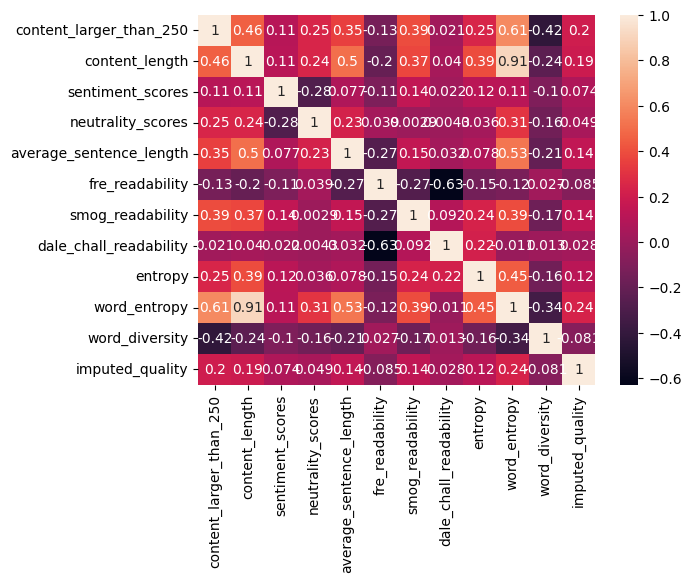

In [ ]:
# cor
import seaborn as sns

no_zero_corr_features = [
    # "default_mse",
    # "overly_negative_mse",
    # "overly_positive_mse",
    # "slider_variance",
    # "time_between_course_and_review",

    # "knn_avg_distance",
    "content_larger_than_250",
    

    "content_length",
    "sentiment_scores",
    "neutrality_scores",
    
    # "polarity",
    # "consistent_polarity",
    
    "average_sentence_length",
    "fre_readability",
    "smog_readability",
    "dale_chall_readability",
    "entropy",
    "word_entropy",
    "word_diversity",

]

no_zero_corr_features.append("imputed_quality")

plt.figure()

sns.heatmap(df_no_zero[no_zero_corr_features].corr(), annot=True)
            
plt.show()